# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Clone the `dlfb` library**  
   First, clone the repository that contains the `dlfb` library.

In [ ]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [ ]:
%%bash
# 1. Download and execute the 'uv' installer script.
# -L: Follow redirects. -s: Silent mode. -S: Show errors. -f: Fail fast on server errors.
curl -LsSf https://astral.sh/uv/install.sh | sh && \

# 2. Add the 'uv' binary directory to your system PATH so you can call 'uv' directly.
# This ensures the shell knows where the newly installed tool is located.
export PATH="/root/.local/bin:${PATH}" && \

# 3. Generate a resolved dependency list (compilation).
# It combines multiple requirement files ({base, dlfb, proteins, gpu}.txt).
# --color never: Disables ANSI color codes for clean logging.
# --constraint: Forces versions to align with a specific 'constraints.txt' file.
uv pip compile ./requirements/{base,dlfb,proteins,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \

# 4. Install the compiled dependencies.
# -r -: Reads the requirements from 'stdin' (the output of the previous 'compile' pipe).
# --system: Installs packages into the global system Python rather than a virtual env.
uv pip install -r - --system

3. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [ ]:
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter proteins

In [ ]:
%%bash
ls -R /content

4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [ ]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

In [ ]:
## Check for GPU
import torch


print(torch.cuda.is_available())
print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Chapter 2. Learning the Language of Proteins

## Biology Primer

This section provides a biological foundation for protein science, emphasizing the deterministic relationship where Sequence $\rightarrow$ Structure $\rightarrow$ Function.

### Protein Structure

Protein structure is organized into a four-level hierarchy, determined by the primary sequence of amino acids.

* **Hierarchical Levels**:
    * **Primary**: The linear chain of amino acids.
    * **Secondary**: Localized folding patterns like -helices and -sheets.
    * **Tertiary**: The complete 3D spatial arrangement of a single polypeptide chain.
    * **Quaternary**: The complex assembly of multiple protein subunits (e.g., Hemoglobin).
* **Amino Acid Properties**: There are 20 main amino acids, categorized by biochemical traits such as hydrophobicity, charge (positive/negative), and polarity.
* **The Impact of Mutations**: Even a single amino acid substitution (point mutation) can be catastrophic.
* *Example*: Sickle cell anemia occurs when a hydrophilic amino acid (E) is replaced by a hydrophobic one (V) in hemoglobin.

<div style='display:flex; justify-content: center'>
    <img src='images/aa.png' width='750px'>
</div>

### Protein Function

Proteins are the primary "workhorses" of the cell. Their functions are systematically categorized using the **Gene Ontology (GO)** framework.
* **Molecular Function**: The specific biochemical activity at the molecular level (e.g., DNA binding or enzyme catalysis).
* **Biological Process**: The larger goal the protein contributes to (e.g., cell division or immune signaling).
* **Cellular Component**: Where the protein is physically located (e.g., mitochondria or nucleus), which often hints at its role.
* **Multi-functionality**: A single protein can have multiple annotations across these categories; for instance, a protein might be a kinase (molecular) that drives muscle contraction (process) in muscle fibers (component).

### Predicting Protein Function

Predicting function from sequence is a "grand challenge" because it requires a model to implicitly understand how sequences fold into 3D shapes.
* **Biotechnology & Engineering**: Designing synthetic enzymes for industry or therapeutic proteins for medicine.
* **Disease Analysis**: Identifying how specific mutations (variants) disrupt healthy functions to find therapeutic targets.
* **Genome & Metagenomics**: Assigning functional hypotheses to the millions of "unknown" proteins discovered in new species or environmental samples (like gut bacteria).
* **Computational Strategy**: While full folding prediction is complex, effective workflows often involve using **pretrained embeddings** to capture biological "language" and training lightweight classifiers on top of them.

---

## Machine Learning Primer

This section bridges the gap between biological sequences and modern AI, explaining how the "language" of proteins can be parsed using the same techniques that power modern LLMs.

### Large Language Models

LLMs are founded on a simple objective that leads to emergent, complex intelligence.

* **Next-Token Prediction**: Models are trained to predict the next character or word (token) based on the preceding context. Variants include **Masked Language Models**, which predict hidden tokens.
* **Emergent Capabilities**: By scaling the number of parameters and the volume of data, models "unsupervisedly" learn to summarize, translate, and reason.
* **Biology as Language**: Because DNA and proteins are sequences from a discrete alphabet with a complex "grammar," they are perfectly suited for LLM architectures.
* **Biological LLMs**: Models like **ESM2** learn rich representations of biological information by being trained on massive corpora of protein sequences.
    
    >**ESM-2:** a state-of-the-art transformer-based protein language model developed by Meta AI (FAIR) that predicts protein structure and function directly from amino acid sequences. Utilizing a BERT-style architecture, it is trained on millions of protein sequences to understand evolutionary, structural, and functional patterns. It enables tasks like mutation effect prediction, protein engineering, and, via ESMFold, rapid 3D structure prediction.


### Embeddings

Embeddings are the bridge between raw biological strings and numerical computation.

* **Numerical Vectors**: An embedding is a compact list of floating-point numbers that encodes the "meaning" of a protein.
* **Latent/Semantic Space**: Similar entities (like related proteins) are positioned near each other in an abstract multi-dimensional space. This allows models to identify functional similarities that aren't obvious from the raw sequence alone.
* **Cosine Similarity**: This is the standard metric used to compare how closely aligned two embedding vectors are. It helps rank the most similar known proteins to a new, uncharacterized query.
    
$$\text{cosine similarity}(A,B) = \frac{A.B}{\lVert A \lVert \lVert B \lVert}$$

### Pretraining and Fine-tuning

This two-stage process allows models to apply general knowledge to specific, high-stakes tasks.

* **Pretraining**: The model gains "broad knowledge" by training on massive, diverse datasets (e.g., all known protein sequences).
* **Fine-tuning**: A secondary step where the pretrained model is updated on a smaller, specialized dataset to perform a specific task (e.g., predicting toxicity).
* **Frozen Feature Extraction**: An efficient alternative to fine-tuning where the large model remains "frozen" (unchanged). It acts as a feature extractor, providing embeddings that are then fed into a much smaller, custom-trained classifier.

---

## Representations of Proteins and Protein LMs

In [26]:
import py3Dmol
import requests


def fetch_protein_structure(pdb_id: str) -> str:
  """Grab a PDB protein structure from the RCSB Protein Data Bank."""
  url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
  response = requests.get(url)
  return response.text


# The Protein Data Bank (PDB) is the main database of protein structures.
# Each structure has a unique 4-character PDB ID. Below are a few examples.
protein_to_pdb = {
  "insulin": "3I40",  # Human insulin – regulates glucose uptake.
  "collagen": "1BKV",  # Human collagen – provides structural support.
  "proteasome": "1YAR",  # Archaebacterial proteasome – degrades proteins.
}

protein = "collagen"  # @param ["insulin", "collagen", "proteasome"]
pdb_structure = fetch_protein_structure(pdb_id=protein_to_pdb[protein])

pdbview = py3Dmol.view(width=400, height=400)
pdbview.addModel(pdb_structure, "pdb")
pdbview.setStyle({"cartoon": {"color": "spectrum"}})
pdbview.zoomTo()
pdbview.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Numerical Representation of a Protein


In [27]:
# Precursor insulin protein sequence (processed into two protein chains).
insulin_sequence = (
  "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)
print(f"Length of the insulin protein precursor: {len(insulin_sequence)}.")

Length of the insulin protein precursor: 110.


### One-Hot Encoding of a Protein Sequence


In [30]:
from dlfb.utils.display import print_short_dict

# fmt: off
amino_acids = [
  "R", "H", "K", "D", "E", "S", "T", "N", "Q", "G", "P", "C", "A", "V", "I",
  "L", "M", "F", "Y", "W",
]
# fmt: on

amino_acid_to_index = {
  amino_acid: index for index, amino_acid in enumerate(amino_acids)
}

print_short_dict(amino_acid_to_index)

{'R': 0, 'H': 1, 'K': 2, 'D': 3, 'E': 4, 'S': 5, 'T': 6, 'N': 7, 'Q': 8, 'G': 9}
…(+10 more entries)


In [31]:
# Methionine, alanine, leucine, tryptophan, methionine.
tiny_protein = ["M", "A", "L", "W", "M"]

tiny_protein_indices = [
  amino_acid_to_index[amino_acid] for amino_acid in tiny_protein
]

tiny_protein_indices

[16, 12, 15, 19, 16]

In [32]:
import jax

one_hot_encoded_sequence = jax.nn.one_hot(
  x=tiny_protein_indices, num_classes=len(amino_acids)
)

print(one_hot_encoded_sequence)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


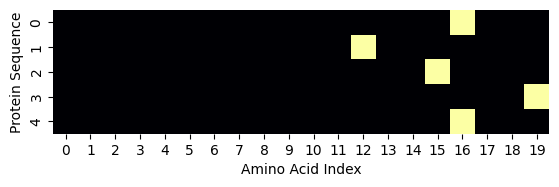

In [33]:
import seaborn as sns

fig = sns.heatmap(
  one_hot_encoded_sequence, square=True, cbar=False, cmap="inferno"
)
fig.set(xlabel="Amino Acid Index", ylabel="Protein Sequence");

Now that we’ve constructed a basic numerical representation of a protein, we’re ready
to move beyond this simplistic format and explore learned embeddings—dense vector
representations that encode much more biological meaning about each amino acid.

### Learned Embeddings of Amino Acids

This section introduces the practical workflow for utilizing state-of-the-art Protein Language Models (PLMs) to generate biological embeddings.

* **ESM2 (Evolutionary Scale Modeling)**: A landmark protein language model released by Meta in 2023. It is designed to capture the "evolutionary grammar" of protein sequences. See [Bonus]() for detailed information.
* **Hugging Face Hub**: The primary platform used to host and access ESM2. It serves as a central repository for thousands of pretrained models across various domains.
* **Transformer Architecture**: ESM2 is built on the **Transformer** neural network architecture, which has been the industry standard for sequence modeling (both text and proteins) since 2017.
* **Cross-Framework Workflow**:
* **PyTorch**: Used initially to load the ESM2 model and extract embeddings, as the official weights are currently only available in this framework.
* **JAX/Flax**: Used for all subsequent processing, analysis, and building custom classifiers on top of the extracted embeddings.
* **Expert Tip**: Modern machine learning workflows often require "framework flexibility"—extracting features in one library and performing high-performance computation in another.



---

### Workflow Comparison

| Component | Tool / Framework | Role |
| --- | --- | --- |
| **Model Source** | Hugging Face | Model hosting and versioning. |
| **Feature Extraction** | PyTorch + ESM2 | Converting amino acid strings into numerical embeddings. |
| **Downstream Logic** | JAX / Flax | Training classifiers and performing scientific computing. |

**Would you like me to show you the specific Python code to bridge the gap between PyTorch and JAX, specifically how to convert a PyTorch tensor into a JAX array without copying the underlying data?**

In [ ]:
from transformers import AutoTokenizer, EsmModel

# Model checkpoint name taken from this GitHub README:
# https://github.com/facebookresearch/esm#available-models-and-datasets-
model_checkpoint = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

In [ ]:
vocab_to_index = tokenizer.get_vocab()
print_short_dict(vocab_to_index)

In [ ]:
tokenized_tiny_protein = tokenizer("MALWM")["input_ids"]
tokenized_tiny_protein

In [ ]:
tokenized_tiny_protein[1:-1]

In [ ]:
token_embeddings = model.get_input_embeddings().weight.detach().numpy()
token_embeddings.shape

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(token_embeddings)
embeddings_tsne_df = pd.DataFrame(
  embeddings_tsne, columns=["first_dim", "second_dim"]
)
embeddings_tsne_df.shape

In [ ]:
fig = sns.scatterplot(
  data=embeddings_tsne_df, x="first_dim", y="second_dim", s=50
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension");

In [ ]:
from adjustText import adjust_text

embeddings_tsne_df["token"] = list(vocab_to_index.keys())

token_annotation = {
  "hydrophobic": ["A", "F", "I", "L", "M", "V", "W", "Y"],
  "polar uncharged": ["N", "Q", "S", "T"],
  "negatively charged": ["D", "E"],
  "positively charged": ["H", "K", "R"],
  "special amino acid": ["B", "C", "G", "O", "P", "U", "X", "Z"],
  "special token": [
    "-",
    ".",
    "<cls>",
    "<eos>",
    "<mask>",
    "<null_1>",
    "<pad>",
    "<unk>",
  ],
}

embeddings_tsne_df["label"] = embeddings_tsne_df["token"].map(
  {t: label for label, tokens in token_annotation.items() for t in tokens}
)

fig = sns.scatterplot(
  data=embeddings_tsne_df,
  x="first_dim",
  y="second_dim",
  hue="label",
  style="label",
  s=50,
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension")
texts = [
  fig.text(point["first_dim"], point["second_dim"], point["token"])
  for _, point in embeddings_tsne_df.iterrows()
]
adjust_text(
  texts, expand=(1.5, 1.5), arrowprops=dict(arrowstyle="->", color="grey")
);

### 2.3.4. The ESM2 Protein Language Model


In [ ]:
insulin_sequence = (
  "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)

masked_insulin_sequence = (
  # Let's mask the `L` amino acid in the 29th position (0-based indexing):
  #       ...LALLALWGPDPAAAFVNQH  L   CGSHLVEALYLVCGERGFF...
  "MALWMRLLPLLALLALWGPDPAAAFVNQH<mask>CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)

# Tokenize the masked insulin sequence.
masked_inputs = tokenizer(masked_insulin_sequence)["input_ids"]

# Check that we indeed have a <mask> token in the place that we expect it. Note
# that the tokenizer adds a <cls> token to the start of the sequence, so we in
# fact expect the <mask> token at position 30 (not 29).
assert masked_inputs[30] == vocab_to_index["<mask>"]

In [ ]:
from transformers import EsmForMaskedLM

# Model checkpoint name taken from this GitHub README:
# https://github.com/facebookresearch/esm#available-models-and-datasets-
model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
masked_lm_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

In [ ]:
import matplotlib.pyplot as plt

model_outputs = masked_lm_model(
  **tokenizer(text=masked_insulin_sequence, return_tensors="pt")
)
model_preds = model_outputs.logits

# Index into the predictions at the <mask> position.
mask_preds = model_preds[0, 30].detach().numpy()

# Apply softmax to convert the model's predicted logits to probabilities.
mask_probs = jax.nn.softmax(mask_preds)

# Visualize the predicted probability of each token.
letters = list(vocab_to_index.keys())
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(letters, mask_probs, color="grey")
plt.xticks(rotation=90)
plt.title("Model Probabilities for the Masked Amino Acid.");

In [ ]:
from dlfb.proteins.inspect import MaskPredictor

display([MaskPredictor])

In [ ]:
MaskPredictor(tokenizer, model=masked_lm_model).plot_predictions(
  sequence=insulin_sequence, mask_index=26
);

### 2.3.5. Strategies for Extracting an Embedding for an Entire Protein
### 2.3.6. Extracellular Versus Membrane Protein Embeddings


In [ ]:
import pandas as pd

from dlfb.utils.context import assets

protein_df = pd.read_csv(assets("proteins/datasets/sequence_df_cco.csv"))
protein_df = protein_df[~protein_df["term"].isin(["GO:0005575", "GO:0110165"])]
num_proteins = protein_df["EntryID"].nunique()
print(protein_df)

In [ ]:
# Filter protein dataframe to proteins with a single location.
num_locations = protein_df.groupby("EntryID")["term"].nunique()
proteins_one_location = num_locations[num_locations == 1].index
protein_df = protein_df[protein_df["EntryID"].isin(proteins_one_location)]

go_function_examples = {
  "extracellular": "GO:0005576",
  "membrane": "GO:0016020",
}

sequences_by_function = {}

min_length = 100
max_length = 500  # Cap sequence length for speed and memory.
num_samples = 20

for function, go_term in go_function_examples.items():
  proteins_with_function = protein_df[
    (protein_df["term"] == go_term)
    & (protein_df["Length"] >= min_length)
    & (protein_df["Length"] <= max_length)
  ]
  print(
    f"Found {len(proteins_with_function)} human proteins\n"
    f"with the molecular function '{function}' ({go_term}),\n"
    f"and {min_length}<=length<={max_length}.\n"
    f"Sampling {num_samples} proteins at random.\n"
  )
  sequences = list(
    proteins_with_function.sample(num_samples, random_state=42)["Sequence"]
  )
  sequences_by_function[function] = sequences

In [ ]:
from dlfb.proteins.dataset import get_mean_embeddings

display([get_mean_embeddings])

In [ ]:
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

In [ ]:
# Compute mean protein embeddings for each location.
protein_embeddings = {
  loc: get_mean_embeddings(sequences_by_function[loc], tokenizer, model)
  for loc in ["extracellular", "membrane"]
}

# Reformat data.
labels, embeddings = [], []
for location, embedding in protein_embeddings.items():
  labels.extend([location] * embedding.shape[0])
  embeddings.append(embedding)
  print(f"{location}: {embedding.shape}")

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components=2, random_state=42).fit_transform(
  np.vstack(embeddings)
)
embeddings_tsne_df = pd.DataFrame(
  {
    "first_dimension": embeddings_tsne[:, 0],
    "second_dimension": embeddings_tsne[:, 1],
    "location": np.array(labels),
  }
)

fig = sns.scatterplot(
  data=embeddings_tsne_df,
  x="first_dimension",
  y="second_dimension",
  hue="location",
  style="location",
  s=50,
  alpha=0.7,
)
plt.title("t-SNE of Protein Embeddings")
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension");

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, EsmModel

from dlfb.utils.context import assets

## 2.4. Preparing the Data
### 2.4.1. Loading the CAFA3 Data


In [ ]:
labels = pd.read_csv(
  assets("proteins/datasets/train_terms.tsv.zip"), sep="\t", compression="infer"
)
print(labels)

In [ ]:
from dlfb.proteins.dataset import get_go_term_descriptions

display(["import obonet", get_go_term_descriptions])

In [ ]:
go_term_descriptions = get_go_term_descriptions(
  store_path=assets("proteins/datasets/go_term_descriptions.csv")
)
print(go_term_descriptions)

In [ ]:
labels = labels.merge(go_term_descriptions, on="term")
print(labels)

In [ ]:
labels = labels[labels["aspect"] == "MFO"]
print(labels["description"].value_counts())

In [ ]:
from Bio import SeqIO

sequences_file = assets("proteins/datasets/train_sequences.fasta")
fasta_sequences = SeqIO.parse(open(sequences_file), "fasta")

data = []
for fasta in fasta_sequences:
  data.append(
    {
      "EntryID": fasta.id,
      "Sequence": str(fasta.seq),
      "Length": len(fasta.seq),
    }
  )
sequence_df = pd.DataFrame(data)
print(sequence_df)

In [ ]:
taxonomy_file = assets("proteins/datasets/train_taxonomy.tsv.zip")
taxonomy = pd.read_csv(taxonomy_file, sep="\t", compression="infer")
print(taxonomy)

In [ ]:
sequence_df = sequence_df.merge(taxonomy, on="EntryID")
sequence_df = sequence_df[sequence_df["taxonomyID"] == 9606]

In [ ]:
sequence_df = sequence_df.merge(labels, on="EntryID")
print(
  f'Dataset contains {sequence_df["EntryID"].nunique()} human proteins '
  f'with {sequence_df["term"].nunique()} molecular functions.'
)

In [ ]:
print(sequence_df)

In [ ]:
sequence_df.groupby("EntryID")["term"].nunique().plot.hist(
  bins=100, figsize=(5, 3), color="grey", log=True
)
plt.xlabel("Number of Molecular Function Annotations per Protein")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Function Counts per Protein")
plt.tight_layout()

In [ ]:
uninteresting_functions = [
  "GO:0003674",  # "molecular function". Applies to 100% of proteins.
  "GO:0005488",  # "binding". Applies to 93% of proteins.
  "GO:0005515",  # "protein binding". Applies to 89% of proteins.
]

sequence_df = sequence_df[~sequence_df["term"].isin(uninteresting_functions)]
sequence_df.shape

In [ ]:
common_functions = (
  sequence_df["term"]
  .value_counts()[sequence_df["term"].value_counts() >= 50]
  .index
)

sequence_df = sequence_df[sequence_df["term"].isin(common_functions)]
sequence_df["term"].value_counts()

In [ ]:
sequence_df = (
  sequence_df[["EntryID", "Sequence", "Length", "term"]]
  .assign(value=1)
  .pivot(
    index=["EntryID", "Sequence", "Length"], columns="term", values="value"
  )
  .fillna(0)
  .astype(int)
  .reset_index()
)
print(sequence_df)

In [ ]:
sequence_df["EntryID"].nunique()

In [ ]:
sequence_df["Sequence"].nunique()

In [ ]:
print(sequence_df[sequence_df["EntryID"].isin(["P0DP23", "P0DP24", "P0DP25"])])

In [ ]:
print(sequence_df.shape)
sequence_df = sequence_df[sequence_df["Length"] <= 500]
print(sequence_df.shape)

### 2.4.2. Splitting the Dataset into Subsets


In [ ]:
from sklearn.model_selection import train_test_split

# 60% of the proteins will go into the training set.
train_sequence_ids, valid_test_sequence_ids = train_test_split(
  list(set(sequence_df["EntryID"])), test_size=0.40, random_state=42
)

# Split the remaining 40% evenly between validation and test sets.
valid_sequence_ids, test_sequence_ids = train_test_split(
  valid_test_sequence_ids, test_size=0.50, random_state=42
)

In [ ]:
sequence_splits = {
  "train": sequence_df[sequence_df["EntryID"].isin(train_sequence_ids)],
  "valid": sequence_df[sequence_df["EntryID"].isin(valid_sequence_ids)],
  "test": sequence_df[sequence_df["EntryID"].isin(test_sequence_ids)],
}

for split, df in sequence_splits.items():
  print(f"{split} has {len(df)} entries.")

### 2.4.3. Converting Protein Sequences into Their Mean Embeddings


In [ ]:
from dlfb.proteins.dataset import (
  load_sequence_embeddings,
  store_sequence_embeddings,
)

display([store_sequence_embeddings, load_sequence_embeddings])

In [ ]:
model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

for split, df in sequence_splits.items():
  store_sequence_embeddings(
    sequence_df=df,
    store_prefix=assets(f"proteins/datasets/protein_dataset_{split}"),
    tokenizer=tokenizer,
    model=model,
  )

In [ ]:
train_df = load_sequence_embeddings(
  assets("proteins/datasets/protein_dataset_train"),
  model_checkpoint=model_checkpoint,
)

print(train_df)

In [ ]:
from dlfb.proteins.dataset import convert_to_tfds

display(["import tensorflow as tf", convert_to_tfds])

In [ ]:
train_ds = convert_to_tfds(train_df, is_training=True)

In [ ]:
batch_size = 32

batch = next(train_ds.batch(batch_size).as_numpy_iterator())
batch["embedding"].shape, batch["target"].shape

In [ ]:
from dlfb.proteins.dataset import build_dataset

display([build_dataset])

In [ ]:
dataset_splits = build_dataset(
  assets("proteins/datasets/protein_dataset"), model_checkpoint=model_checkpoint
)

In [ ]:
import jax
import numpy as np
import pandas as pd

from dlfb.proteins.dataset import (
  build_dataset,
  get_go_term_descriptions,
  load_sequence_embeddings,
)
from dlfb.utils.context import assets

go_term_descriptions = get_go_term_descriptions(
  store_path=assets("proteins/datasets/go_term_descriptions.csv")
)

model_checkpoint = "facebook/esm2_t30_150M_UR50D"

train_df = load_sequence_embeddings(
  store_file_prefix=f"{assets('proteins/datasets/protein_dataset')}_train",
  model_checkpoint=model_checkpoint,
)

dataset_splits = build_dataset(
  assets("proteins/datasets/protein_dataset"), model_checkpoint=model_checkpoint
)
batch = next(dataset_splits["train"].as_numpy_iterator())

## 2.5. Training the Model


In [ ]:
from dlfb.proteins.model import Model

display(
  ["import flax.linen as nn\nfrom flax.training import train_state\n", Model]
)

In [ ]:
targets = list(train_df.columns[train_df.columns.str.contains("GO:")])

mlp = Model(num_targets=len(targets))

### 2.5.1. Defining the Training Loop


In [ ]:
from dlfb.proteins.train import train_step

display([train_step])

In [ ]:
from dlfb.proteins.train import compute_metrics

display(["import sklearn", compute_metrics])

In [ ]:
from dlfb.proteins.train import calculate_per_target_metrics, eval_step

display([eval_step, calculate_per_target_metrics])

In [ ]:
from dlfb.proteins.train import train

display([train])

In [ ]:
import optax

from dlfb.utils.restore import restorable

# Initiate training state with dummy data from a single batch.
rng = jax.random.PRNGKey(42)
rng, rng_init = jax.random.split(key=rng, num=2)

state, metrics = restorable(train)(
  state=mlp.create_train_state(
    rng=rng_init, dummy_input=batch["embedding"], tx=optax.adam(0.001)
  ),
  dataset_splits=dataset_splits,
  batch_size=32,
  num_steps=300,
  eval_every=30,
  store_path=assets("proteins/models/mlp"),
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot training loss curve.
learning_data = pd.concat(
  pd.DataFrame(metrics[split]).melt("step").assign(split=split)
  for split in ["train", "valid"]
)

sns.lineplot(
  ax=ax[0],
  x="step",
  y="value",
  hue="split",
  data=learning_data[learning_data["variable"] == "loss"],
  palette=DEFAULT_SPLIT_COLORS,
)
ax[0].set_title("Loss over training steps.")

# Plot validation metrics curves.
sns.lineplot(
  ax=ax[1],
  x="step",
  y="value",
  hue="variable",
  style="variable",
  data=learning_data[learning_data["variable"] != "loss"],
  palette="Set2",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("Validation metrics over training steps.");

### 2.5.2. Examining the Model Predictions


In [ ]:
valid_df = load_sequence_embeddings(
  store_file_prefix=f"{assets('proteins/datasets/protein_dataset')}_valid",
  model_checkpoint=model_checkpoint,
)

# Use batch size of 1 to avoid dropping the remainder.
valid_probs = []
for valid_batch in dataset_splits["valid"].batch(1).as_numpy_iterator():
  logits = state.apply_fn({"params": state.params}, x=valid_batch["embedding"])
  valid_probs.extend(jax.nn.sigmoid(logits))

valid_true_df = valid_df[["EntryID"] + targets].set_index("EntryID")
valid_prob_df = pd.DataFrame(
  np.stack(valid_probs), columns=targets, index=valid_true_df.index
)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

sns.heatmap(
  ax=ax[0],
  data=valid_true_df,
  yticklabels=False,
  xticklabels=False,
  cmap="flare",
)
ax[0].set_title("True functional annotations by protein.")
ax[0].set_xlabel("Functional category")

sns.heatmap(
  ax=ax[1],
  data=valid_prob_df,
  yticklabels=False,
  xticklabels=False,
  cmap="flare",
)
ax[1].set_title("Predicted functional annotations by protein.")
ax[1].set_xlabel("Functional category");

In [ ]:
metrics_by_function = {}
for function in targets:
  metrics_by_function[function] = compute_metrics(
    valid_true_df[function].values, valid_prob_df[function].values
  )

overview_valid = (
  pd.DataFrame(metrics_by_function)
  .T.merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("auprc", ascending=False)
)
print(overview_valid)

In [ ]:
# Compute number of occurences of each function in the training set.
overview_valid = overview_valid.merge(
  pd.DataFrame(train_df[targets].sum(), columns=["train_n"]),
  left_index=True,
  right_index=True,
)
print(overview_valid)

In [ ]:
fig = sns.scatterplot(
  x="train_n", y="auprc", data=overview_valid, alpha=0.5, s=50, color="grey"
)
fig.set_xlabel("# Train instances")
fig.set_ylabel("Validation auPRC");

### 2.5.3. Evaluating Model Usefulness


In [ ]:
def make_coin_flip_predictions(
  valid_true_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
  """Make random coin flip predictions for each protein function."""
  predictions = np.random.choice([0.0, 1.0], size=valid_true_df.shape)
  return pd.DataFrame(predictions, columns=targets, index=valid_true_df.index)


def make_proportional_predictions(
  valid_true_df: pd.DataFrame, train_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
  """Make random protein function predictions proportional to frequency."""
  percent_1_train = dict(train_df[targets].mean())
  proportional_preds = []
  for target_column in targets:
    prob_1 = percent_1_train[target_column]
    prob_0 = 1 - prob_1
    proportional_preds.append(
      np.random.choice([0.0, 1.0], size=len(valid_true_df), p=[prob_0, prob_1])
    )
  return pd.DataFrame(
    np.stack(proportional_preds).T, columns=targets, index=valid_true_df.index
  )

In [ ]:
prediction_methods = {
  "coin_flip_baseline": make_coin_flip_predictions(valid_true_df, targets),
  "proportional_guess_baseline": make_proportional_predictions(
    valid_true_df, train_df, targets
  ),
  "model": valid_prob_df,
}

In [ ]:
metrics_by_method = {}
for method, preds_df in prediction_methods.items():
  metrics_by_method[method] = pd.DataFrame(
    [
      compute_metrics(valid_true_df.iloc[i], preds_df.iloc[i])
      for i in range(len(valid_true_df))
    ]
  ).mean()

print(pd.DataFrame(metrics_by_method))

In [ ]:
auprc_by_function = {}

for method, preds_df in prediction_methods.items():
  metrics_by_function = {}

  for function in targets:
    metrics_by_function[function] = compute_metrics(
      valid_true_df[function], preds_df[function]
    )

  auprc_by_function[method] = (
    pd.DataFrame(metrics_by_function)
    .T.merge(go_term_descriptions, left_index=True, right_on="term")
    .set_index("term")
    .sort_values("auprc", ascending=False)
  )["auprc"].to_dict()

In [ ]:
best_performing = (
  pd.DataFrame(auprc_by_function)
  .merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("model", ascending=False)
  .head(20)
  .melt("description")
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
  x="description",
  y="value",
  hue="variable",
  data=best_performing,
)
ax.set_title("The model's 20 best performing protein functions")
ax.set_ylabel("Validation auPRC")
plt.xticks(rotation=90);

### 2.5.4. Conducting a Final Check on the Test Set


In [ ]:
eval_metrics = []

for split in ["valid", "test"]:
  split_metrics = []

  for eval_batch in dataset_splits[split].batch(32).as_numpy_iterator():
    split_metrics.append(eval_step(state, eval_batch))

  eval_metrics.append(
    {"split": split, **pd.DataFrame(split_metrics).mean(axis=0).to_dict()}
  )
print(pd.DataFrame(eval_metrics))

## 2.6. Improvements and Extensions
### 2.6.1. Biological and Analytical Exploration
### 2.6.2. Machine Learning Improvements


## 2.7. Summary


---

## Bonus materials

### ESM2

ESM2 is a series of transformer-based protein language models developed by Meta AI (formerly Facebook AI). These models are designed to understand protein sequences by learning from evolutionary patterns in biological sequences. For technical details, review the original research paper [here](https://www.science.org/doi/10.1126/science.ade2574).

#### Model Architecture & Design

##### Core Architecture
- **Type**: Transformer-based protein language model
- **Architecture**: Based on the standard Transformer decoder-only architecture
- **Positional Embeddings**: Supports both absolute and rotary positional embeddings
- **Max Sequence Length**: 1026 tokens

##### Key Design Features
- Trained using **masked language modeling (MLM)** objective
- Focuses on evolutionary relationships in protein sequences
- Designed to capture both secondary and tertiary structural information
- Uses a causal attention mask for autoregressive properties

#### Available Models

The ESM2 series comes in multiple sizes to accommodate different computational needs:

| Model Name | Parameters | Downloads | Hidden Size | Layers | Heads |
|------------|-----------|-----------|------------|--------|-------|
| facebook/esm2_t6_8M_UR50D | 8M | 601.9K | 320 | 6 | 20 |
| facebook/esm2_t12_35M_UR50D | 35M | 433.5K | 640 | 12 | 32 |
| facebook/esm2_t30_150M_UR50D | 150M | 101K | 1280 | 30 | 40 |
| facebook/esm2_t33_650M_UR50D | 650M | 35.7M | 1600 | 33 | 40 |
| facebook/esm2_t36_3B_UR50D | 3B | 506.9K | 2560 | 36 | 40 |
| facebook/esm2_t48_15B_UR50D | 15B | 1.2K | 5120 | 48 | 40 |

#### Technical Specifications

##### Model Configuration
- **Framework**: PyTorch, TensorFlow
- **Library**: Hugging Face Transformers
- **License**: MIT License
- **Task**: Primarily fill-mask (masked language modeling)
- **Tokenizer**: Specialized protein tokenizer with amino acid vocabulary

##### Training Details
- **Training Objective**: Masked Language Modeling (MLM)
- **Training Data**: Protein sequences from UniRef50 database
- **Context**: Evolutionary-scale modeling of protein sequences

#### Key Capabilities

##### Protein Structure Understanding
- Encodes information about protein secondary structure
- Captures tertiary structure relationships
- Enables atomic resolution structure prediction
- Outperforms other single-sequence protein language models

##### Performance Advantages
- Better representation learning for proteins compared to earlier models
- Can extract meaningful features without multiple sequence alignments
- Effective for zero-shot and few-shot protein analysis tasks

#### Usage with Transformers

##### Basic Implementation
```python
from transformers import AutoTokenizer, AutoModel
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

# Example usage
protein_sequence = "MKTVRQERLKSIVRILERSKEPVSGAIEAEAKKIRE"
inputs = tokenizer(protein_sequence, return_tensors="pt")

# Get embeddings
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
```

##### Fill-Mask Task
```python
from transformers import pipeline

# Create fill-mask pipeline for protein sequences
fill_mask = pipeline("fill-mask", model="facebook/esm2_t6_8M_UR50D")

# Predict masked amino acids
result = fill_mask("MKT[R]QERLKSIVRILERSK")
print(result)
```

#### Applications

##### Primary Use Cases
1. **Protein Sequence Analysis**: Understanding protein function and evolution
2. **Structure Prediction**: When combined with ESMFold for 3D structure prediction
3. **Feature Extraction**: Generating embeddings for downstream tasks
4. **Protein Engineering**: Designing novel proteins with desired properties

##### Downstream Tasks
- Protein function prediction
- Protein-protein interaction prediction
- Protein stability prediction
- Enzyme engineering
- Antibody analysis
- Drug target identification

#### Integration with ESMFold

ESM2 serves as the foundation for **ESMFold**, Meta's protein structure prediction system:
- ESM2 provides the language model backbone
- ESMFold builds upon ESM2 representations for 3D structure prediction
- Together, they enable end-to-end protein structure prediction from sequence

#### Access and Resources

##### Hugging Face Resources
- **Model Hub**: Available on Hugging Face at [facebook/esm2 models](https://huggingface.co/facebook)
- **Documentation**: Comprehensive transformers documentation available
- **Demo Spaces**: Multiple demo applications showcasing protein analysis
- **Community**: Active community with examples and tutorials

##### Installation
```bash
pip install transformers torch
```

#### Research and Development

##### Research Applications
- Studying protein evolution and conservation
- Identifying functional domains in proteins
- Predicting the impact of mutations
- Protein design and engineering

##### Ongoing Development
- Integration with other biological modalities
- Fine-tuning for specific protein families
- Multimodal applications combining sequence and structure

#### Limitations and Considerations

##### Computational Requirements
- Larger models (3B, 15B parameters) require significant GPU memory
- Inference time increases with model size
- 15B parameter model has limited downloads, suggesting specialized use

#### Biological Context
- Trained primarily on natural protein sequences
- May have limitations with highly engineered or synthetic proteins
- Performance may vary across protein families

#### Community and Support

##### Available Resources
- **GitHub Repository**: Part of the Hugging Face ecosystem
- **Documentation**: Detailed API documentation
- **Tutorials**: Step-by-step guides for common tasks
- **Community Forums**: Active discussion and support

#### Related Models
- **ESM-1**: Previous generation of Evolutionary Scale Models
- **ESM-Fold**: Protein structure prediction model based on ESM
- **ProteinBert**: Alternative protein language models

The ESM2 models represent a significant advancement in protein language modeling, enabling researchers to analyze and understand protein sequences with unprecedented depth and accuracy. The models are particularly valuable for bioinformatics, structural biology, and protein engineering applications.